# Analysis - Twitter Data and Socioeconomic Data

Author: Fangzheng Lyu

This notebook is related to the paper [Mapping dynamic human sentiments of heat exposure with location-based social media data](https://www.tandfonline.com/doi/full/10.1080/13658816.2024.2343063)

This notebook combines Twitter data and socioeconomic data, and investigate the relationship between human sentiments of heat exposure and different socioeconomic data.

## Notebook Outline
- [Collect Socioeconomic Data and Human Sentiments of Heat Exposure](#collect)
- [Exploratory Analysis](#analysis)
- [OLS Regression](#regression)
- [Pearson and Spearman Correlation](#correlation)

Import necessary library

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import csv
from urllib.request import urlopen
import pandas as pd
import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

<a id='collect'></a>

## 1. Collect Socioeconomic Data and Human Sentiments of Heat Exposure

### Collect socioeconomic data from US Census Bureau American Community Survey (ACS)

Please refer to the data collection notebook if you want more information about ACS data collection

In [2]:
## Forming template
## Get social economic data
## example for retrieveing 2018 acs data using API
def get_url(state_id):
    ## Total population, black, white, hispanic, asian, income
    
    s1_t = "https://api.census.gov/data/2018/acs/acs5?get=B02001_001E,B02001_003E,B02001_002E,B03001_003E,B02001_005E,B25105_001E&for=county:*&in=state:"
    
    s_state = str(state_id)
    if (len(s_state)==1):
        s_state = "0"+s_state
    return [s1_t+s_state]
state_id = [1,2,4,5,6,8,9,10,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56,72]

In [3]:
## Run this cell if the the socioeconomic data is not collected yet
## If you have already collected the socioeocnomic data using the data collection notebook
## Skip this block
!rm -r ./rt

Collect data from ACS data API, and store the data in the rt folder

In [4]:
!mkdir ./rt
for i in range(0, len(state_id)):
    state_url = get_url(state_id[i])
    curr_id = state_id[i]
    head_rt = []
    data_rt = []

    link = state_url[0]
    #print("Currently on state ID " + str(state_id[i]))
    ## print(link)
    f = urlopen(link)
    myfile = f.read()
    myfile = str(myfile)
    data = myfile.split("\\n")
    head = data[0].split(",")
    head[0] = head[0][4:]
    head = head[:-1]
    #print(head)
    head[-1]=head[-1][:-1]
    data = data[1:]
    data_arr = []
    for i in range(0, len(data)):
        curr_arr = data[i].split(",")[:-1]
        curr_arr[0]=curr_arr[0][1:]
        curr_arr[-1]=curr_arr[-1][:-1]
        for j in range(0, len(curr_arr)):
            curr_arr[j]=curr_arr[j]
        data_arr.append(curr_arr)
    head_rt = head[-3:]+head[:-3]
    for i in range(0,len(data_arr)):
        curr_arr = data_arr[i]
        data_rt.append(curr_arr[-3:]+curr_arr[:-3])
    link = state_url[0]
    ## print(link)
    f = urlopen(link)
    myfile = f.read()
    myfile = str(myfile)
    data = myfile.split("\\n")
    head = data[0].split(",")
    head[0] = head[0][4:]
    head = head[:-1]
    head[-1]=head[-1][:-1]
    data = data[1:]
    data_arr = []
    for i in range(0, len(data)):
        curr_arr = data[i].split(",")[:-1]
        curr_arr[0]=curr_arr[0][1:]
        curr_arr[-1]=curr_arr[-1][:-1]
        for j in range(0, len(curr_arr)):
            curr_arr[j]=curr_arr[j]
        data_arr.append(curr_arr)
    head_rt = head_rt+head[:-3]
    for i in range(0,len(data_arr)):
        #print(len(curr_arr))
        curr_arr = data_arr[i]
        data_rt[i]=data_rt[i]+curr_arr[:-3]
    for i in range(0,len(data_rt)):
        for j in range(0,len(data_rt[i])):
            #print(str(i)+" "+str(j))
            if (data_rt[i][j]!="null"):
                data_rt[i][j]=data_rt[i][j][1:-1]
        
    filename = "rt/data_state_"+str(curr_id)+".csv"
    ##print(filename)
    final_rt = []
    final_rt.append(head_rt)
    for i in range(0, len(data_rt)):
        final_rt.append(data_rt[i])
    with open(filename,"w+") as my_csv:
        csvWriter = csv.writer(my_csv)
        csvWriter.writerows(final_rt)

Create a dataframe to store all the socioeconomic data collected.

In [5]:
## Read csv file
soc = pd.DataFrame(columns=['state', 'county', 'pop', 'black', 'white', 'asian', 'hispanic', 'income'])

In [6]:
soc

,state,county,pop,black,white,asian,hispanic,income


In [7]:
state_code = [1,2,4,5,6,8,9,10,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56,72]
for code in state_code:
    #print(code)
    filepath = "rt/data_state_"+str(code)+".csv"

    state = pd.read_csv(filepath)


    pop = state['"B02001_001E"'][:-1]
    black = state['"B02001_003E"'][:-1]
    white = state['"B02001_002E"'][:-1]
    asian = state['"B02001_005E"'][:-1]
    hispanic = state['"B03001_003E"'][:-1]
    income = state['"B25105_001E"'][:-1]
    state_id = state['"state"'][:-1]
    county = state['"county"'][:-1]

    temp= pd.DataFrame(columns=['state', 'county', 'pop', 'black', 'white', 'asian', 'hispanic', 'income'])
    temp['state']=state_id
    temp['county']=county
    temp['pop'] = pop
    temp['black'] = black/pop
    temp['white'] = white/pop
    temp['asian'] = asian/pop
    temp['hispanic'] = hispanic/pop
    temp['income'] = income

    soc = pd.concat([soc, temp], ignore_index=True)

In [8]:
soc

,state,county,pop,black,white,asian,hispanic,income
0,1,115,87306,0.094518,0.873067,0.008442,0.023927,779
1,1,43,82313,0.012124,0.952365,0.004058,0.043043,671
2,1,69,104352,0.269070,0.693681,0.008366,0.032937,736
3,1,125,206213,0.316469,0.644368,0.016013,0.036065,891
4,1,31,51288,0.172146,0.758910,0.012985,0.069197,739
...,...,...,...,...,...,...,...,...
3163,72,47,34165,0.064920,0.796371,0.000000,0.989639,230
3164,72,95,11023,0.729293,0.254649,0.000000,0.988479,197
3165,72,113,143926,0.054431,0.773856,0.000660,0.993483,272
3166,72,131,37964,0.028738,0.702718,0.002766,0.977953,222


### Read the national-level human sentiments of heat exposure for analysis

In [9]:
## read the csv file
df = pd.read_csv('./human_sentiments_of_heat/national_heat_exposure.csv')
df

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure,number_of_twitter_for_quantile
0,5,121,69178,0500000US05121,5121,Randolph,Randolph County,AR,Arkansas,6,1688445990,10370823,"POLYGON ((-91.404915 36.49712, -91.12653766071...",0,NaN,NaN,NaN
1,8,69,198150,0500000US08069,8069,Larimer,Larimer County,CO,Colorado,6,6723014102,98984559,"POLYGON ((-106.190554078709 40.9977466125744, ...",18,-0.292958,0.429290,18.0
2,26,105,1622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,6,1281963206,1935616622,"POLYGON ((-86.514702 44.058119, -86.4580652757...",0,NaN,NaN,NaN
3,28,153,695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,6,2099745602,7255476,"POLYGON ((-88.943355 31.824565, -88.910459 31....",0,NaN,NaN,NaN
4,38,75,1034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,6,2272050275,40658499,"POLYGON ((-102.021643 48.807108, -102.02121763...",0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,77,394951,0500000US16077,16077,Power,Power County,ID,Idaho,6,3635892401,99205466,"POLYGON ((-113.243478 43.110946, -113.007712 4...",0,NaN,NaN,NaN
3217,46,85,1265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,6,4253498542,167300393,"POLYGON ((-100.367247 44.194621, -99.938216999...",0,NaN,NaN,NaN
3218,55,115,1581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,6,2313441749,41883059,"POLYGON ((-89.223814 45.029246, -88.98168 45.0...",1,-0.145698,0.471636,1.0
3219,16,69,399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,6,2197139835,21252880,"POLYGON ((-117.035545 46.410012, -117.03664574...",0,NaN,NaN,NaN


<a id='analysis'></a>

## 2. Exploratory Analysis

### Histogram for human sentiments of heat exposure

In [10]:
## Find the hitogram of normailized heat index
nhe = list(df["normalized_heat_exposure"])
## remove non-existing value
nhe_list = []
for e in nhe:
    if (e>=0 and e<=1):
        nhe_list.append(e)
len(nhe_list)

1230

Text(0.5, 1.0, 'Histogram of Normailized Heat Exposure for counties')

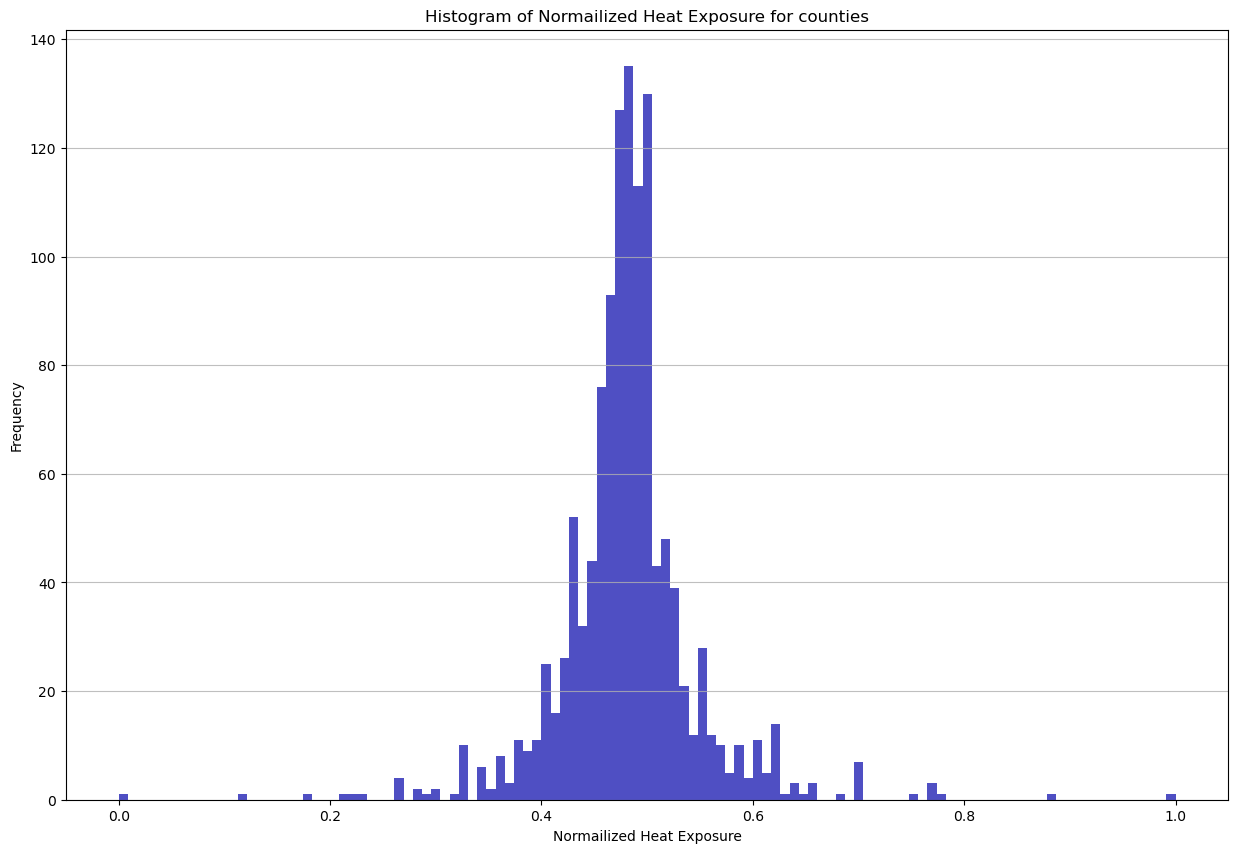

In [11]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.hist(nhe_list, bins='auto', color='#0504aa',alpha=0.7)
plt.grid(axis='y', alpha=0.8)
plt.xlabel('Normailized Heat Exposure')
plt.ylabel('Frequency')
plt.title('Histogram of Normailized Heat Exposure for counties')

### Join two dataframe (socioeconomic dataframe and the human sentiments of heat exposure dataframe)

In [12]:
## merge two dataframe
GEOID = []
for index, row in soc.iterrows():
    state = str(int(row['state']))
    county = str(int(row['county']))
    while (len(county)!=3):
        #print(county)
        county = '0'+county
    geo = state+county
    GEOID.append(int(geo))
soc["GEOID"] = GEOID
df_soc = pd.merge(df, soc, on='GEOID')

In [13]:
## setset for dataframe that has not
county_with_twitter = df_soc[df_soc["number_of_twitter"]!=0]

In [14]:
county_with_twitter

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,normalized_heat_exposure,number_of_twitter_for_quantile,state,county,pop,black,white,asian,hispanic,income
1,8,69,198150,0500000US08069,8069,Larimer,Larimer County,CO,Colorado,6,...,0.429290,18.0,8,69,338161,0.009685,0.914561,0.022194,0.113328,1292
9,40,101,1101838,0500000US40101,40101,Muskogee,Muskogee County,OK,Oklahoma,6,...,0.445345,1.0,40,101,69084,0.107883,0.582117,0.007238,0.060274,675
12,48,259,1383915,0500000US48259,48259,Kendall,Kendall County,TX,Texas,6,...,0.537316,2.0,48,259,41982,0.007694,0.902434,0.008789,0.235672,1314
13,31,79,835861,0500000US31079,31079,Hall,Hall County,NE,Nebraska,6,...,0.503134,1.0,31,79,61343,0.024991,0.876775,0.011265,0.272305,796
17,18,109,450375,0500000US18109,18109,Morgan,Morgan County,IN,Indiana,6,...,0.389737,1.0,18,109,69727,0.003040,0.974945,0.007243,0.015102,900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,39,91,1074058,0500000US39091,39091,Logan,Logan County,OH,Ohio,6,...,0.429663,1.0,39,91,45307,0.016797,0.947160,0.008586,0.015031,796
3159,28,89,695768,0500000US28089,28089,Madison,Madison County,MS,Mississippi,6,...,0.484897,51.0,28,89,103498,0.380548,0.570939,0.025566,0.029508,1052
3160,49,43,1448035,0500000US49043,49043,Summit,Summit County,UT,Utah,6,...,0.490283,1.0,49,43,40511,0.007504,0.939597,0.016465,0.115080,1585
3161,37,189,1008594,0500000US37189,37189,Watauga,Watauga County,NC,North Carolina,6,...,0.489530,5.0,37,189,54117,0.016631,0.939150,0.009535,0.034777,805


### Scatter plot between normailized heat exposure from Twitter and differernt socioeconomic indicators

Normalized Heat Exposure & Population

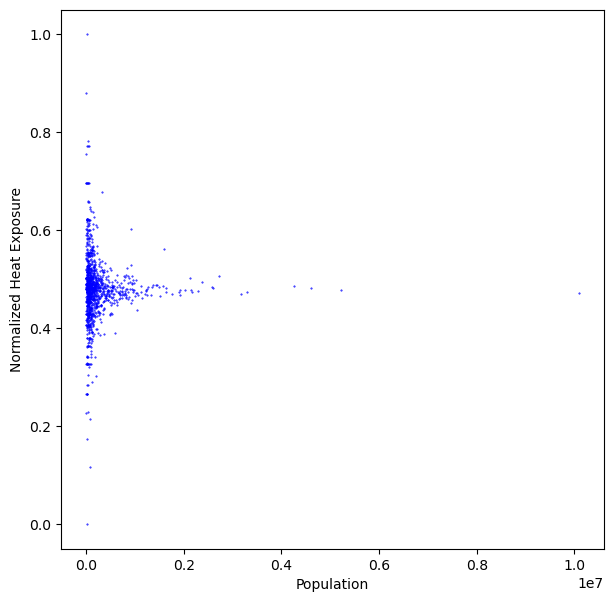

In [15]:
import matplotlib.pyplot as plt
## pop
x = list(county_with_twitter['pop'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Population')
plt.ylabel('Normalized Heat Exposure')
plt.show()

Normalized Heat Exposure & Ethnic group

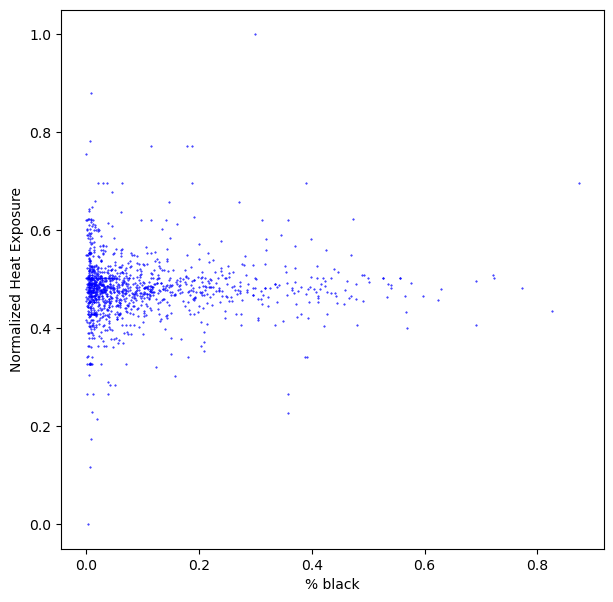

In [16]:
x = list(county_with_twitter['black'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% black')
plt.ylabel('Normalized Heat Exposure')
plt.show()

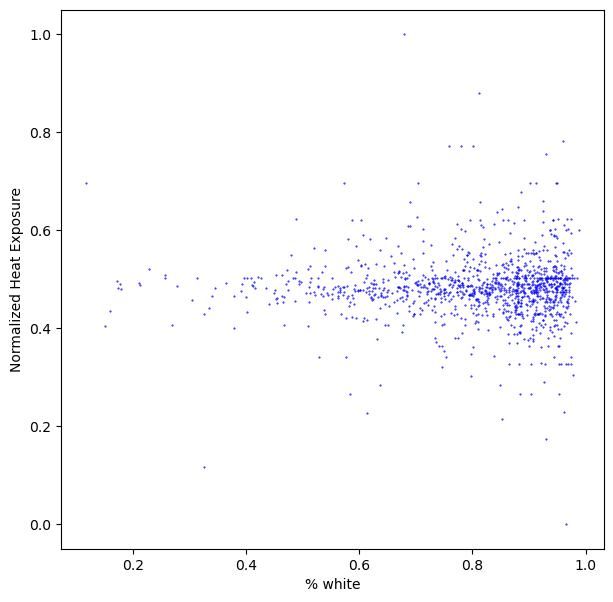

In [17]:
x = list(county_with_twitter['white'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% white')
plt.ylabel('Normalized Heat Exposure')
plt.show()

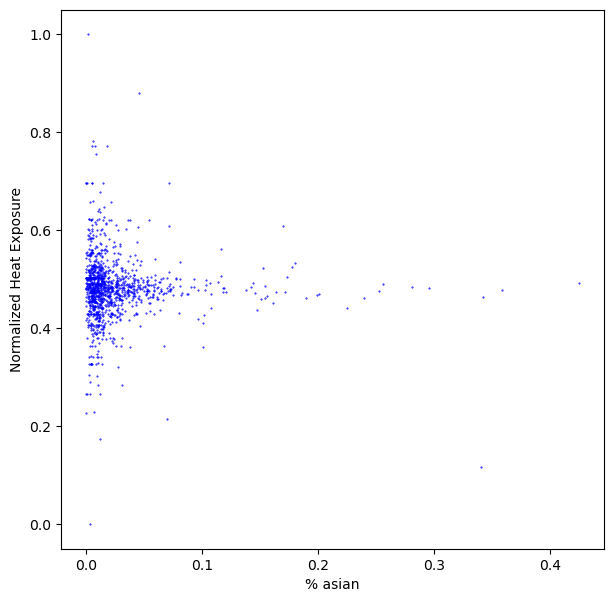

In [18]:
x = list(county_with_twitter['asian'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% asian')
plt.ylabel('Normalized Heat Exposure')
plt.show()

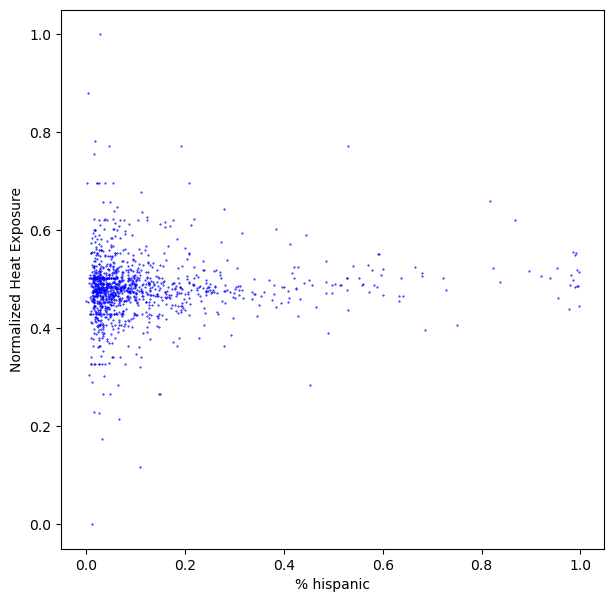

In [19]:
x = list(county_with_twitter['hispanic'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% hispanic')
plt.ylabel('Normalized Heat Exposure')
plt.show()

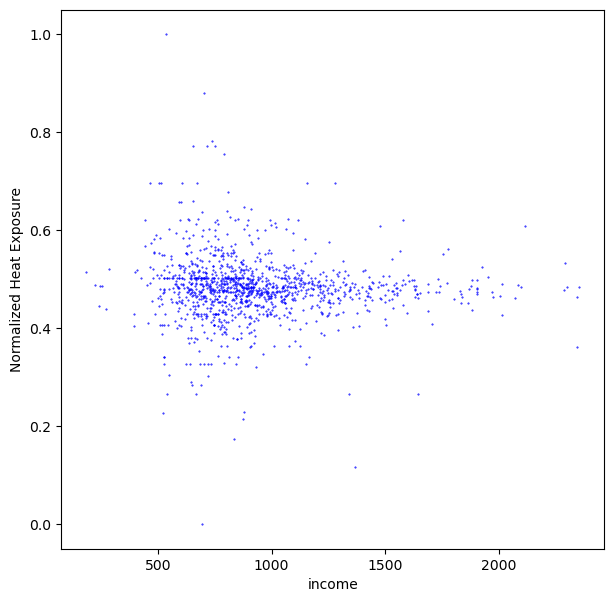

In [20]:
x = list(county_with_twitter['income'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('income')
plt.ylabel('Normalized Heat Exposure')
plt.show()

<a id='regression'></a>

## 3. OLS Regression

### Ordinary Least Squares Analysis

Ordinary Least Squares (OLS) is a method for estimating the unknown parameters in a linear regression model by minimizing the sum of squared differences between the observed values and the values predicted by the linear model. OLS finds the best-fitting line by minimizing the squared residuals under certain assumptions about the error term.

In [21]:
model = ols('normalized_heat_exposure ~ black+white+asian+hispanic', data=county_with_twitter).fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     normalized_heat_exposure   R-squared:                       0.010
Model:                                  OLS   Adj. R-squared:                  0.007
Method:                       Least Squares   F-statistic:                     3.026
Date:                      Wed, 12 Jun 2024   Prob (F-statistic):             0.0170
Time:                              18:53:35   Log-Likelihood:                 1570.6
No. Observations:                      1205   AIC:                            -3131.
Df Residuals:                          1200   BIC:                            -3106.
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4508      0.029     15.672      0.000       0.394       0.507
black          0.0465      0.032      1.452      0.147      -0.016       0.109
white          0.0288      0.030      0.965      0.335      -0.030       0.087
asian         -0.0553      0.066     -0.838      0.402      -0.185       0.074
hispanic       0.0370      0.013      2.892      0.004       0.012       0.062
==============================================================================
Omnibus:                      240.647   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4660.107
Skew:                           0.352   Prob(JB):                         0.00
Kurtosis:                      12.608   Cond. No.                         52.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA test

The ANOVA (Analysis of Variance) test is a statistical method used to analyze the differences among group means in a study. In two sentences: The ANOVA test examines whether the means of two or more groups are significantly different from each other by analyzing the variance within and between groups. It determines if the variation between group means is larger than the expected variation within groups, indicating a statistically significant difference.

In [23]:
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
black,0.009150,1.0,2.109744,0.146625
white,0.004038,1.0,0.931117,0.334767
asian,0.003048,1.0,0.702717,0.402039
hispanic,0.036281,1.0,8.365273,0.003894
Residual,5.204518,1200.0,NaN,NaN


<a id='correlation'></a>

## 4. Pearson and Spearman Correlation

Format data

In [24]:
pop = list(county_with_twitter["pop"])
bla = list(county_with_twitter["black"])
whi = list(county_with_twitter["white"])
asi = list(county_with_twitter["asian"])
his = list(county_with_twitter["hispanic"])
inc = list(county_with_twitter["income"])

y = list(county_with_twitter["normalized_heat_exposure"])

### Pearson Correlation

The Pearson correlation coefficient, denoted as r, ranges between -1 and 1, indicating the strength and direction of the linear association between two variables - a value close to 1 shows a strong positive linear relationship, a value close to -1 shows a strong negative linear relationship, and a value close to 0 indicates little or no linear relationship. It is widely used to quantify the degree to which two variables move together.

In [25]:
print(scipy.stats.pearsonr(pop, y))

PearsonRResult(statistic=-0.01368357463728154, pvalue=0.6351229564643196)


### Spearman correlation

Spearman's correlation coefficient assesses monotonic relationships, whether linear or not, based on the ranked values of the two variables. It is calculated by applying the Pearson correlation formula to the ranks of the data, making it useful when the data violates the assumptions of Pearson's correlation, such as non-linearity or non-normality.

In [26]:
print(scipy.stats.spearmanr(pop, y))

SignificanceResult(statistic=-0.06966332198726725, pvalue=0.015577809691934095)
